## Gradient boosting

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
df = pd.read_csv("./pv_extended.csv").drop(['Unnamed: 0'],axis=1)
df.head(2)

,acuvim_PmEAct,Met_WdSpd,Met_Temp,Met_IrrGloHoztl,Met_IrrPOA,date,PeriodEnd,Period,AirTemp,CloudOpacity,Dhi,Dni,Ebh,Ghi
0,0.000000,0.00,0.000000,0.00000,0.000000,2020-10-01 01:00:00,2020-10-01 01:05:00+00:00,PT5M,12.2,58.6,0.0,0.0,0.0,0.0
1,0.018546,3.25,9.428571,0.08982,0.090361,2020-10-01 01:05:00,2020-10-01 01:10:00+00:00,PT5M,12.1,56.3,0.0,0.0,0.0,0.0


In [4]:
X = np.asarray([df.Ghi.to_numpy(), df.AirTemp.to_numpy()] ).T
y = np.asarray(df.acuvim_PmEAct) 

In [5]:
X.shape, y.shape

((8928, 2), (8928,))

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def scale_X(X):
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)

X = scale_X(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 13)

params = {'n_estimators': 1000,
          'max_depth': 2,
          'min_samples_split': 5,
          'learning_rate': 0.006,
          'loss': 'ls'}

In [25]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))


The mean squared error (MSE) on test set: 1161.2036


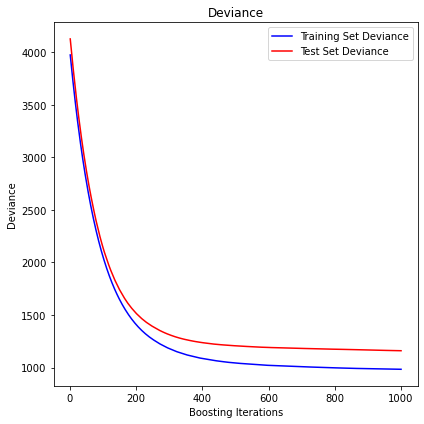

In [26]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()


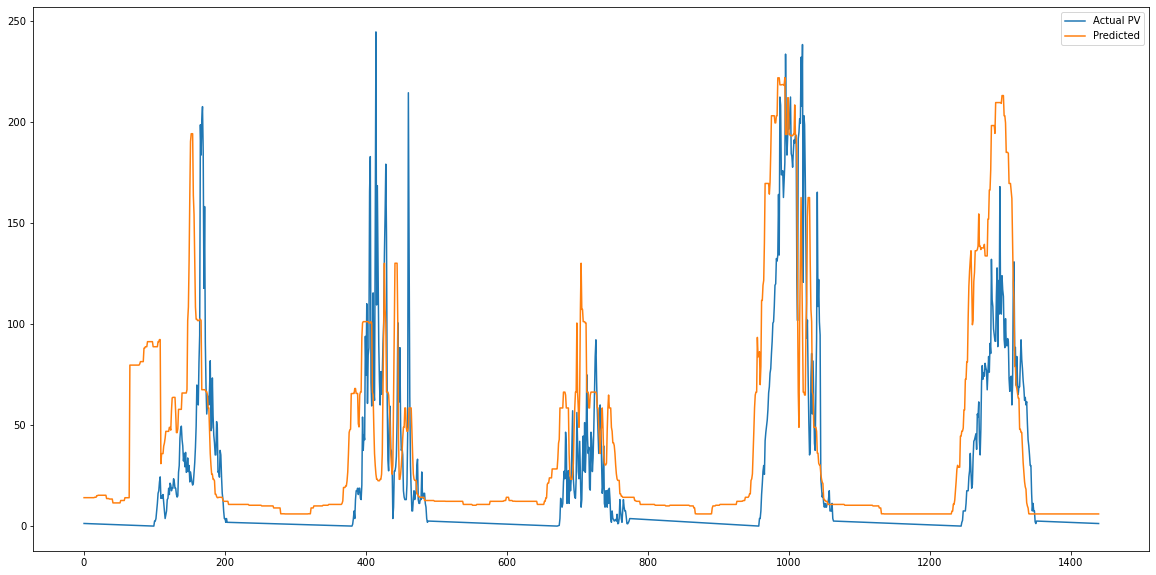

7568.737338046698

In [20]:
df_test = df[(df['date'] > "2020-10-25") & (df['date'] < "2020-10-30")]
X_secret = np.asarray([df_test.Ghi.to_numpy(), df_test.AirTemp.to_numpy()]).T
X_secret = scale_X(X_secret)

y_true = df_test.acuvim_PmEAct.to_numpy()
y_pred = reg.predict(X_secret)

plt.figure(figsize=(20, 10))
plt.plot(range(df_test.shape[0]), y_true)
plt.plot(range(len(y_pred)), y_pred)
plt.legend(["Actual PV", "Predicted"])
plt.show()

mean_absolute_percentage_error(y_true, y_pred)

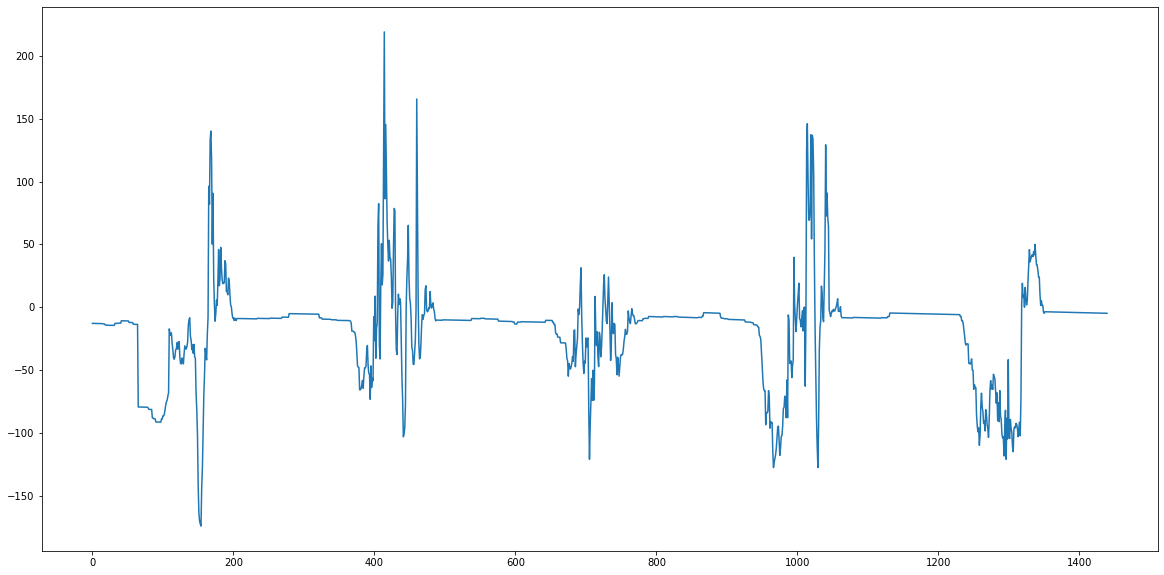

In [22]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(y_pred)), y_true - y_pred)
plt.show()